### Modele

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import recall_score, precision_score, f1_score, matthews_corrcoef, roc_auc_score, roc_curve, plot_roc_curve, plot_precision_recall_curve, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

c:\users\beljasiak\appdata\local\programs\python\python39\lib\site-packages\pkg_resources\__init__.py:122: PkgResourcesDeprecationWarning: 0.0.07d6de2784363a81e65d5af245dc41b3e71eb65b5- is an invalid version and will not be supported in a future release
  warnings.warn(


### Ponownie korzystamy z zbioru `adult`

In [2]:
data = pd.read_csv("../data/adult.csv")

In [3]:
y = data["pay_>50K"]
X = data.drop("pay_>50K", axis = 1)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=420, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=420, test_size=0.125)

## Szybki powrót do poprzednich labów
I wyjaśnienie błędu przy tworzeniu krzywej ROC

In [4]:
def plot_cm_and_recall(model, X_train, X_test, y_train, y_test):
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    train_recall = recall_score(y_train, y_pred_train)
    test_recall = recall_score(y_test, y_pred_test)
    
    fig, axs = plt.subplots(ncols=2)
    cm = ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred_train))
    cm.plot(colorbar=False, ax=axs[0])
    axs[0].set_title(f"Train (recall {train_recall:.03f})")
    
    cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test))
    cm.plot(colorbar=False, ax=axs[1])
    axs[1].set_title(f"Test (recall {test_recall:.03f})")
    plt.show()

In [5]:
def lab_recall_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    if tp+fn == 0:
        return 0
    return tp/(tp+fn)

# by torchę uprościć liczę jednak False Positive Rate, zamiast 1 - specisivity, natomiast wynik jest ten sam
def lab_fpr_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    if tn+fn == 0:
        return 0
    return fp/(fp+tn)

In [6]:
def lab_plot_roc_curve(y_true, y_pred_proba, steps = 100):
    thresholds = np.linspace(0,1, steps)
    recall_scores = np.full((steps,), 0.0)
    fpr_scores = np.full((steps,), 0.0)
    for i in range(steps):
        y_pred = (y_pred_proba[:,1]>thresholds[i])*1 # <- tutaj wcześniej braliśmy y_pred_proba[:,0], co oznacza, ze zamieniliśmy klasę 1 z 0
        recall_scores[i] = lab_recall_score(y_true, y_pred)
        fpr_scores[i] = lab_fpr_score(y_true, y_pred) # <- wykorzystujemy wspomniane fpr
    
    auc = roc_auc_score(y_true, y_pred_proba[:,1]) # <- oraz dorzuciłem 'area under the curve' score
    plt.figure(figsize=(6,6))
    plt.plot(np.linspace(0,1),np.linspace(0,1))
    plt.plot(fpr_scores, recall_scores) 
    plt.title(f"ROC curve: AUC = {auc:0.3f}")
    plt.ylabel("Recall")
    plt.xlabel("False Positive Rate")
    plt.show()

### Stwórzmy bazowy, naiwny model

In [7]:
rf = RandomForestClassifier(n_estimators=10, random_state=420)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=420)

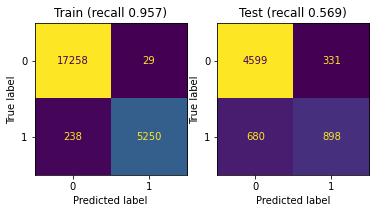

In [8]:
plot_cm_and_recall(rf, X_train, X_test, y_train, y_test)

In [9]:
f1_score(y_test, rf.predict(X_test))

0.6398289989312433

krzywa ROC dla naiwnego modelu

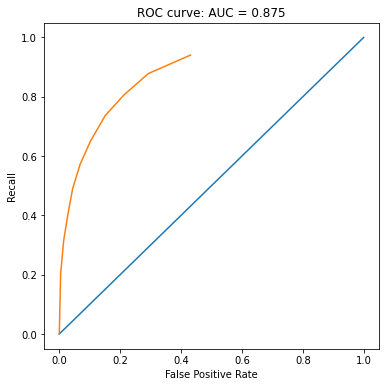

In [10]:
lab_plot_roc_curve(y_test, rf.predict_proba(X_test))

#### porównanie z `sklearn`

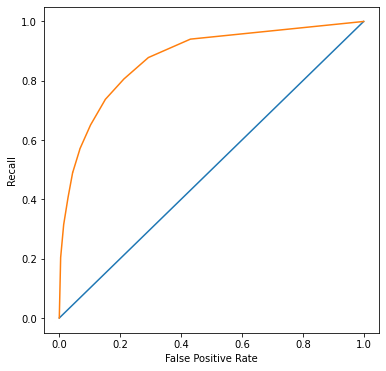

In [11]:
fpr, tpr, threshold = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
plt.figure(figsize=(6,6))
plt.plot(np.linspace(0,1),np.linspace(0,1))
plt.plot(fpr, tpr)
plt.ylabel("Recall")
plt.xlabel("False Positive Rate")
plt.show()

In [12]:
rf = RandomForestClassifier(class_weight='balanced', min_samples_split=10, n_estimators=10, random_state=420)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', min_samples_split=10,
                       n_estimators=10, random_state=420)

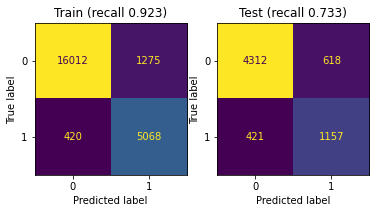

In [13]:
plot_cm_and_recall(rf, X_train, X_test, y_train, y_test)

In [14]:
f1_score(y_test, rf.predict(X_test))

0.6901282433641515

udało nam się delikatnie poprawić wynik

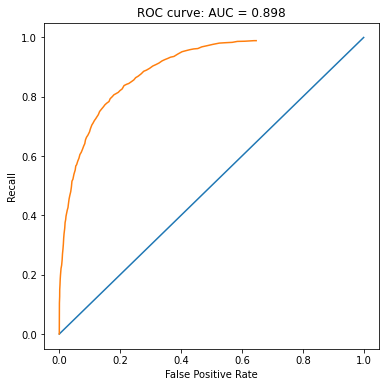

In [15]:
lab_plot_roc_curve(y_test, rf.predict_proba(X_test))

### Wieloklasowe agregacje metryk opartych o macierz błędu (confusion matrix)
Ale o co chodzi? W przypadku klasyfikacji binarnej wiadomym jest czym jest błąd w predykcji False Positive i False Negative. Od razu daje nam to możliwośc policzenia wielu metryk korzystających z tych oznaczeń tj. recall, f1_score, roc_auc.  Natomias w momencie gdy klas jest więcej, dalej łatwo zliczyć jest poprawne zakwalifikowania dla konkretnych klas, natomiast pozostaje pytanie jak agregować informacje o skutecznosci predykcji wszystkich klas. 

In [16]:
y_true = [2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 1, 1, 2, 0, 1, 0, 0, 2, 2]
y_pred = [0, 1, 2, 2, 0, 1, 2, 0, 0, 2, 1, 0, 1, 0, 1, 2, 2, 1, 1]
cm_vals = confusion_matrix(y_true, y_pred)

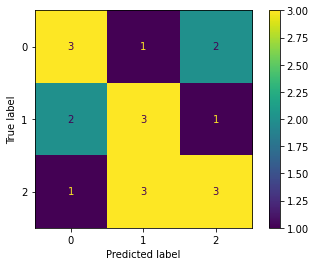

In [17]:
cm = ConfusionMatrixDisplay(cm_vals)
cm.plot()
plt.show()

policzenie accuracy jest banalne, natomiast jak zliczyć np. recall? opcji jest kilka
### Agregacje 'binary', 'micro', 'macro', 'weighted', 'samples'

In [18]:
f1_score

<function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>

In [19]:
print(f1_score.__doc__)

Compute the F1 score, also known as balanced F-score or F-measure.

    The F1 score can be interpreted as a weighted average of the precision and
    recall, where an F1 score reaches its best value at 1 and worst score at 0.
    The relative contribution of precision and recall to the F1 score are
    equal. The formula for the F1 score is::

        F1 = 2 * (precision * recall) / (precision + recall)

    In the multi-class and multi-label case, this is the average of
    the F1 score of each class with weighting depending on the ``average``
    parameter.

    Read more in the :ref:`User Guide <precision_recall_f_measure_metrics>`.

    Parameters
    ----------
    y_true : 1d array-like, or label indicator array / sparse matrix
        Ground truth (correct) target values.

    y_pred : 1d array-like, or label indicator array / sparse matrix
        Estimated targets as returned by a classifier.

    labels : array-like, default=None
        The set of labels to include when ``a

Wszystkie metryki bazujace na wartościach z macierzy błędu mogą agregować statystyki wielu klas na kilka sposóbów. 

### Binary
ustawienie domyślne, działa tylko dla klasyfikacji binarnej

### Micro
Przekształaca problem wieloklasowy w binarny, zliczając wszystkie wartości true positive, false negative and false positives. 

In [20]:
recall_score(y_true, y_pred, average='micro')

0.47368421052631576

In [21]:
accuracy_score(y_true, y_pred)

0.47368421052631576

In [22]:
precision_score(y_true, y_pred, average='micro')

0.47368421052631576

In [23]:
f1_score(y_true, y_pred, average='micro')

0.47368421052631576

### Macro
Przekształaca problem wieloklasowy w binarny, zliczając wszystkie wartości true positive, false negative and false positives. 

In [24]:
recall_score(y_true, y_pred, average='macro')

0.4761904761904762

### Weighted
Przekształaca problem wieloklasowy w binarny, zliczając wszystkie wartości true positive, false negative and false positives. 

In [25]:
recall_score(y_true, y_pred, average='weighted')

0.47368421052631576

### Samples
Przekształaca problem wieloklasowy w binarny, zliczając wszystkie wartości true positive, false negative and false positives. 

In [26]:
recall_score(pd.get_dummies(y_true), pd.get_dummies(y_pred), average='samples')

0.47368421052631576

### Współczynniki modelu

In [27]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [28]:
recall_score(y_test, lr.predict(X_test))

0.5576679340937896

In [29]:
lr.coef_[0][:5]

array([ 4.85942488e-03, -2.89037618e-06,  3.10304147e-04,  7.41694509e-04,
        4.43229846e-03])

In [30]:
importances = pd.DataFrame([X_train.columns.values, np.abs(lr.coef_[0])]).T
importances.columns = ["Feature", "coef"]
importances = importances.sort_values('coef')
importances

,Feature,coef
6,workclass_Never-worked,0.0
34,occupation_Armed-Forces,0.0
19,education_Assoc-acdm,0.0
11,workclass_Without-pay,0.000001
58,native-country_Germany,0.000001
...,...,...
31,marital-status_Never-married,0.000401
29,marital-status_Married-civ-spouse,0.000536
3,capital-loss,0.000742
4,hours-per-week,0.004432


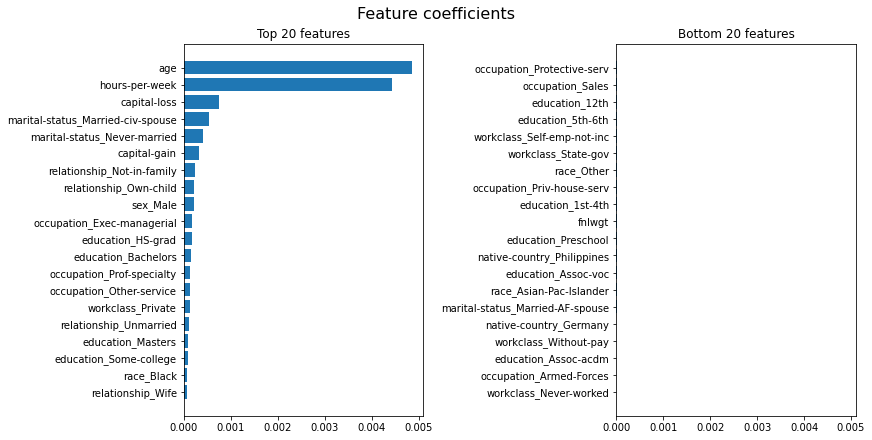

In [31]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6), sharex=True, constrained_layout=True)
fig.suptitle('Feature coefficients', fontsize=16)
axs[0].barh(importances['Feature'].iloc[-20:], importances['coef'].iloc[-20:])
axs[0].set_title("Top 20 features")
axs[1].barh(importances['Feature'].iloc[:20], importances['coef'].iloc[:20])
axs[1].set_title("Bottom 20 features")
plt.show()

Współczynniki takiej postaci posiadają natomiast tylko modele liniowe, jak inaczej sprawdzić istotność zmiennych?

### Feature importance
Ale czym tak naprawdę jest feature importance? wróćmy do [dokumentacji](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest#sklearn.ensemble.RandomForestClassifier.feature_importances_) sklearn

W przypadku sklearn ważność danej cechy to: całkowity spadek impurity w węźle ją wykorzystującym pomnożony przez prawdopodbieństwo dotarcia do danego węzła, uśrednione po wszystkich drzewach [trochę detali](https://alexisperrier.com/datascience/2015/08/27/feature-importance-random-forests-gini-accuracy.html).

In [33]:
rf.coef_

AttributeError: 'RandomForestClassifier' object has no attribute 'coef_'

In [34]:
rf.feature_importances_[:5]

array([0.13389761, 0.07616953, 0.07980362, 0.0248482 , 0.06688352])

In [35]:
importances = pd.DataFrame([X_train.columns.values, rf.feature_importances_]).T
importances.columns = ["Feature", "importance"]
importances = importances.sort_values('importance')
importances

,Feature,importance
6,workclass_Never-worked,0.0
34,occupation_Armed-Forces,0.000003
11,workclass_Without-pay,0.000031
25,education_Preschool,0.00023
41,occupation_Priv-house-serv,0.000287
...,...,...
1,fnlwgt,0.07617
2,capital-gain,0.079804
31,marital-status_Never-married,0.103667
29,marital-status_Married-civ-spouse,0.111366


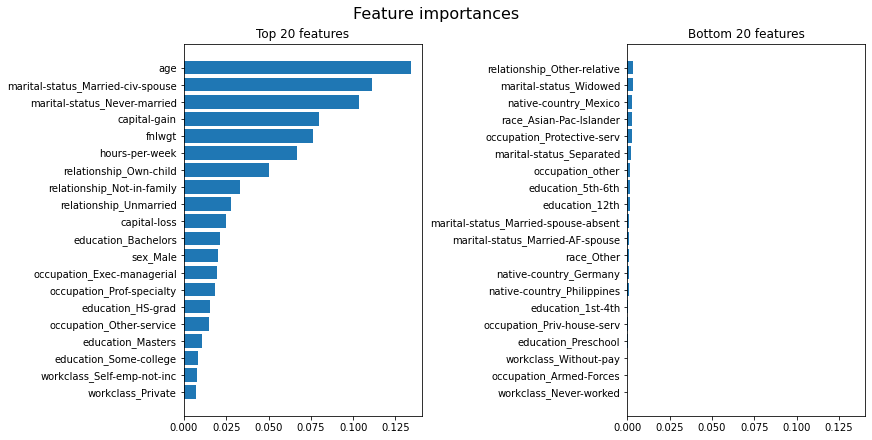

In [36]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6), sharex=True, constrained_layout=True)
fig.suptitle('Feature importances', fontsize=16)
axs[0].barh(importances['Feature'].iloc[-20:], importances['importance'].iloc[-20:])
axs[0].set_title("Top 20 features")
axs[1].barh(importances['Feature'].iloc[:20], importances['importance'].iloc[:20])
axs[1].set_title("Bottom 20 features")
plt.show()

## Inspekcja predykcji
na podstawie pakietu [shap](https://shap.readthedocs.io/en/latest/)

In [37]:
import shap

In [38]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [39]:
f1_score(y_test, lr.predict(X_test))

0.43052837573385516

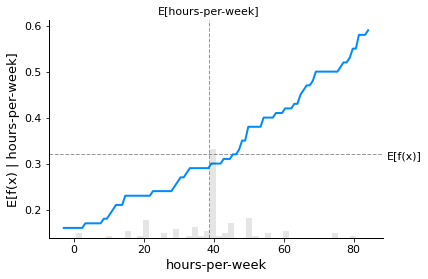

In [40]:
X_sample = shap.utils.sample(X_val, 100)
shap.plots.partial_dependence("hours-per-week", lr.predict, X_sample, ice=False,model_expected_value=True, feature_expected_value=True)

In [41]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(lr.predict, X_sample)
shap_values = explainer(X_val)

Permutation explainer: 3255it [00:58, 47.22it/s]                                                                       


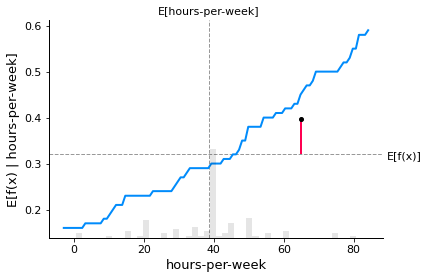

In [42]:
# make a standard partial dependence plot
sample_ind = 1
shap.partial_dependence_plot(
    "hours-per-week", lr.predict, X_sample, model_expected_value=True,
    feature_expected_value=True, ice=False,
    shap_values=shap_values[sample_ind:sample_ind+1,:]
)

### Zastosowanie wartości Shapley
Wartości shapley mają właściwość, że jeżeli zaczniemy od bazowej estymacji modelu, a następnie będziemy dodawac wartość shapley związaną z każdą cechą to na końcu otrzymamy tą samą predykcję, którą dał nam nasz model. 

Daje nam to bardzo atrakcyjne wizualnie narzędzie, którym możemy posłużyć się by tłumaczyć zachowanie naszego modelu, oraz decyzji, które on podjął.

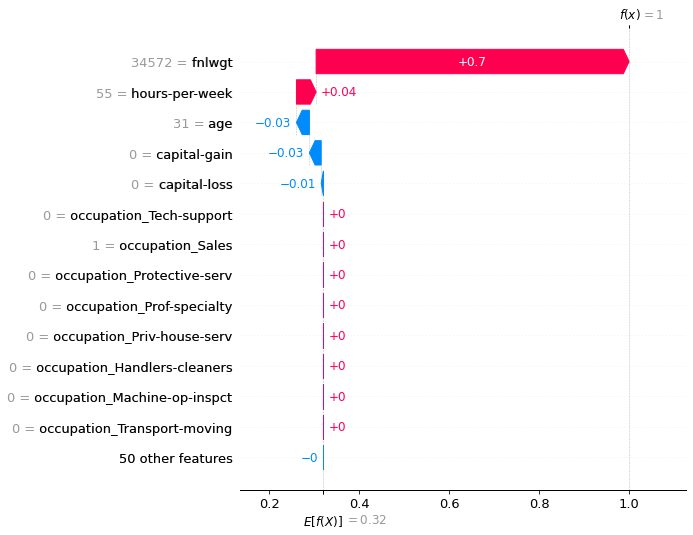

In [43]:
shap.plots.waterfall(shap_values[7], max_display=14)

Jednocześnie dla małych modeli oraz danych możemy przyglądac się jak zmieniają się wartości shapley w zależnosci od wielkości zmiennej dnych kolumn

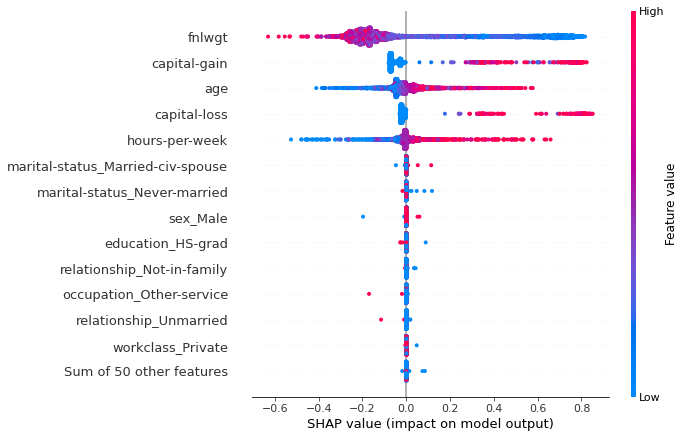

In [44]:
shap.plots.beeswarm(shap_values, max_display=14)

## Shap values impact

In [45]:
X_val.iloc[[0]]

,age,fnlwgt,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native-country_Germany,native-country_Mexico,native-country_Philippines,native-country_United-States,native-country_other
31256,49,122206,0,0,25,0,0,1,0,0,...,0,0,0,1,1,0,0,0,1,0


In [48]:
explainer = shap.TreeExplainer(rf, X_val)

In [49]:
sample = X_val.iloc[[0]]
shap_values = explainer.shap_values(sample)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], sample)

In [50]:
sample = X_val.iloc[[2]]
shap_values = explainer.shap_values(sample)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], sample)

## Reprodukowalność artykułów naukowych
Jednym z najważniejszych aspektów artykułów naukowych jest ich szczegułowość oraz związana z nią reprodukowalność. Logicznym jest, że nie wystarczy ogłosić światu, że stworzyło się nowy najlepszy model uczenia maszynowego, trzeba tego jeszcze jakoś dowieść. Dzieje się to na kilka różnych sposbów:
- dowody matematyczne
- reprodukowalność wyników kodu
- reprodukowalność wyników modeli uczenia maszynowego